## Health Care Analysis - Preprocessing Dimensionality Reduction

### 1) Data Load

In [2]:
# import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# read dataset
dataset = pd.read_excel("../dataset/reddim_health_data_46d_v2.xlsx")
dataset.head()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,...,x37,x38,x39,x40,x41,x42,x43,x44,x45,x46
0,-0.204495,0.706923,-0.670797,0.627508,-0.511963,0.101840,-0.635477,0.022242,-0.331430,0.123567,...,-0.494278,0.792750,0.744401,0.342039,0.297775,0.652350,-0.150965,0.421695,-0.109940,0.721649
1,0.063239,0.187908,-0.387678,-0.352767,-0.434383,-0.637019,0.693801,0.238969,0.578612,-0.638544,...,-0.311816,0.793611,0.748710,0.313666,0.759477,0.405378,0.680289,-0.610442,-0.110089,0.720513
2,0.443743,0.680222,-0.502748,-0.084745,-0.154669,0.328483,0.277291,0.232948,-0.367870,-0.636853,...,-0.018246,-0.553286,0.708282,-0.285098,-0.585789,0.658857,-0.190356,0.574346,-0.109960,0.552427
3,-0.432062,-0.012342,-0.670705,-0.400712,-0.507101,0.316319,-0.031358,-0.458494,-0.587550,0.709924,...,-0.494482,0.374265,0.582586,-0.572834,0.762800,-0.645115,-0.538970,-0.338480,-0.031505,-0.564490
4,-0.204495,0.692697,-0.035888,0.041904,-0.507101,0.313794,-0.630210,0.616945,0.570170,-0.299147,...,-0.424001,0.723464,0.472905,0.681048,0.761816,0.434044,-0.190173,0.173512,-0.110202,0.720513


### 2) Distance correlation

In [4]:
import numpy as np
from scipy.spatial.distance import pdist, squareform

def distance_pairs_correlation(x, y):

    # ensure numpy data type and reshape it 
    x = np.array(x).reshape(-1, 1)
    y= np.array(y).reshape(-1, 1)

    # Compute distance matrices
    A = squareform(pdist(x))
    B = squareform(pdist(y))
    
    # Double-centering
    n = len(x)
    A_row_means = A.mean(axis=1)
    A_col_means = A.mean(axis=0)
    A_mean = A.mean()
    A_centered = A - A_row_means[:, np.newaxis] - A_col_means + A_mean
    
    B_row_means = B.mean(axis=1)
    B_col_means = B.mean(axis=0)
    B_mean = B.mean()
    B_centered = B - B_row_means[:, np.newaxis] - B_col_means + B_mean

    # Compute dCor components
    cov_AB = (A_centered * B_centered).sum() / (n**2)
    var_A = (A_centered**2).sum() / (n**2)
    var_B = (B_centered**2).sum() / (n**2)

    denominator = np.sqrt(var_A * var_B)
    if denominator == 0:
        return 0.0
    
    return np.sqrt(cov_AB / denominator)

In [5]:
def matrix_dist_correlations(data):
    columns = data.columns
    n = len(columns)
    m_dist = np.zeros((n, n))

    for i_idx, i_col in enumerate(columns):
        for j_idx, j_col in enumerate(columns):
            # pass the currently distance pair correlation values 
            m_dist[i_idx, j_idx] = distance_pairs_correlation(data[i_col], data[j_col])
        
    return m_dist

In [6]:
# make the correlation for our 40 x 46 features
corr_matrix = matrix_dist_correlations(dataset)
corr_matrix.shape

(46, 46)

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_corr_matrix(data, corr_matrix):
    variables = data.columns
    plt.figure(figsize=(24, 20))

    # Create heatmap with annotations
    ax = sns.heatmap(
        corr_matrix,
        annot=True,            # Show values in cells
        fmt=".1f",             # 2 decimal places
        cmap="coolwarm",       # Blue-white-red color scheme
        vmin=0, vmax=1,        # Fix color range between 0-1
        square=True,           # Square cells
        linewidths=0.1,         # Add grid lines
        cbar_kws={"shrink": 0.5, "label": "Correlation"}, # Color bar size
        xticklabels=variables,
        yticklabels=variables,        
    )

    # Adjust tick labels for readability
    ax.set_xticklabels(
        ax.get_xticklabels(),
        rotation=90,
        ha='center',
        fontsize=8  # Smaller font
    )

    ax.set_yticklabels(
        ax.get_yticklabels(),
        fontsize=8
    )

    # Improve readability
    plt.title("Distance Correlation Matrix", fontsize=16, pad=20)
    plt.tight_layout()
    plt.savefig("corr_matrix.png", dpi=300, bbox_inches='tight')
    plt.show()
     


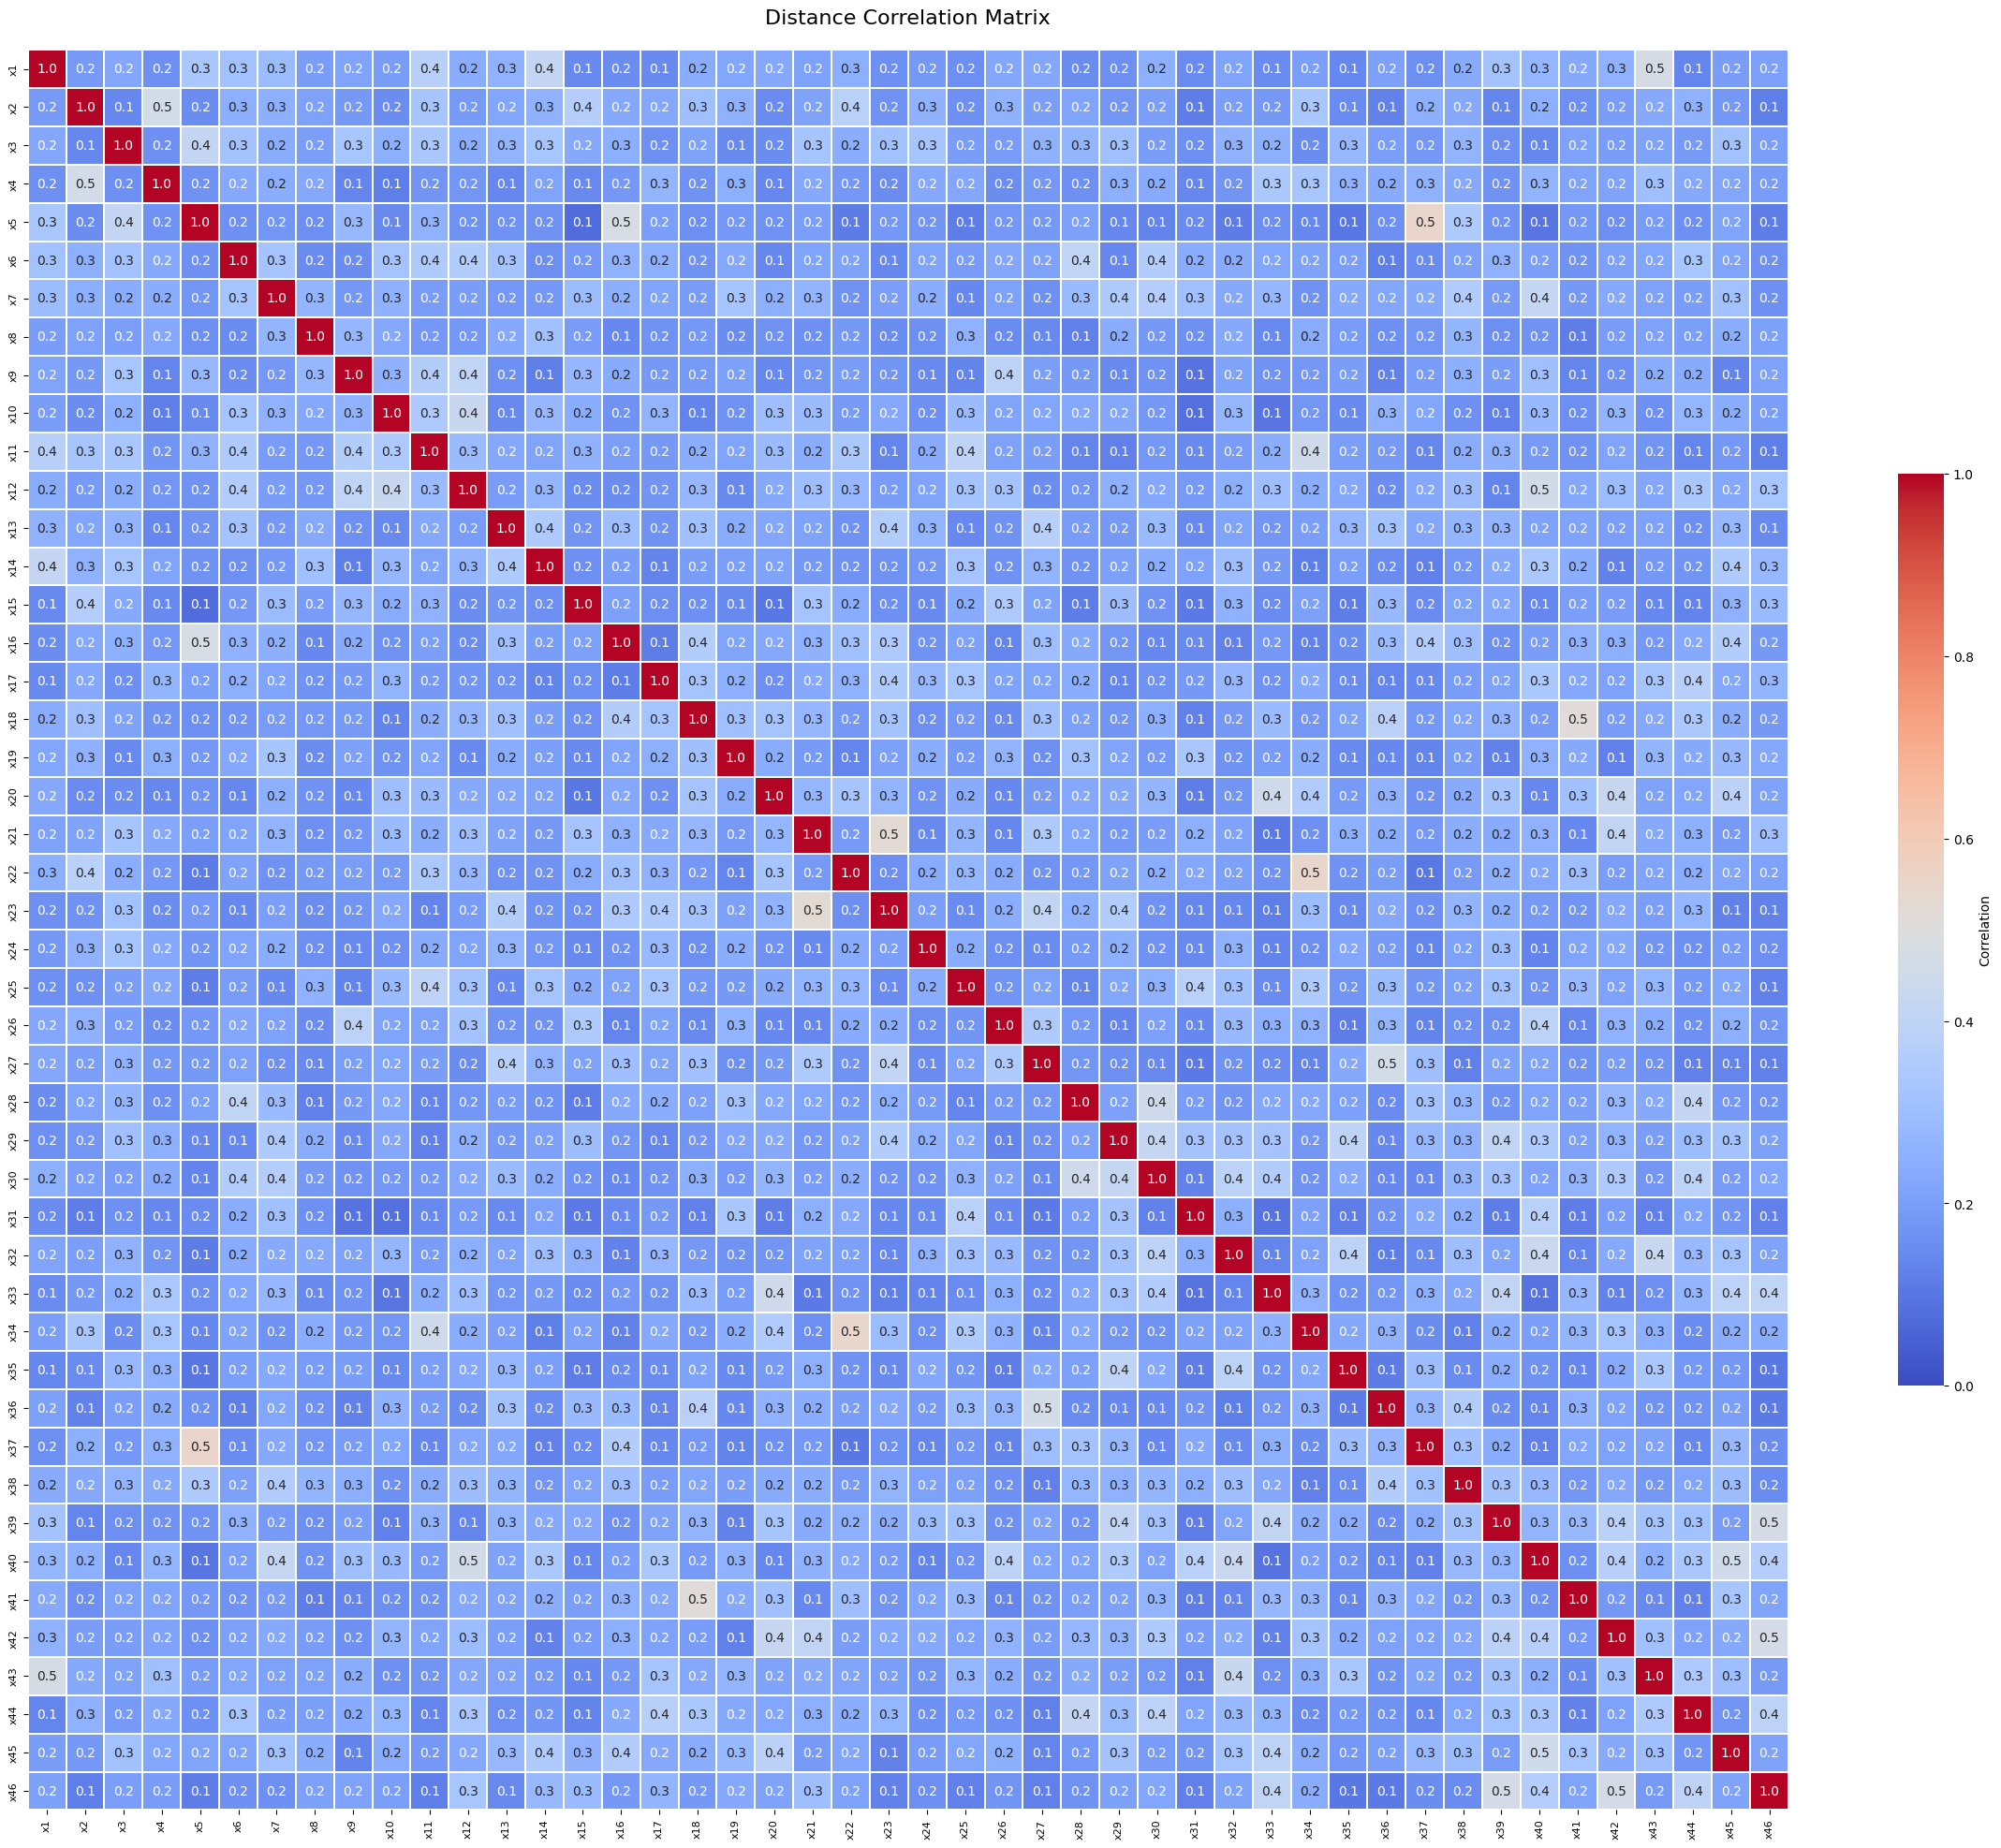

In [8]:
plot_corr_matrix(dataset, corr_matrix)

### 3) Feature Selection 
Mutual information Analysis X --> Y (Non-linear relationships measurement) strategy

Mutual information (MI) measures the dependence between two random variables, capturing both linear and non-linear relationships. MI quantifies how much information one variable provides about another, regardless of the relationship's form.

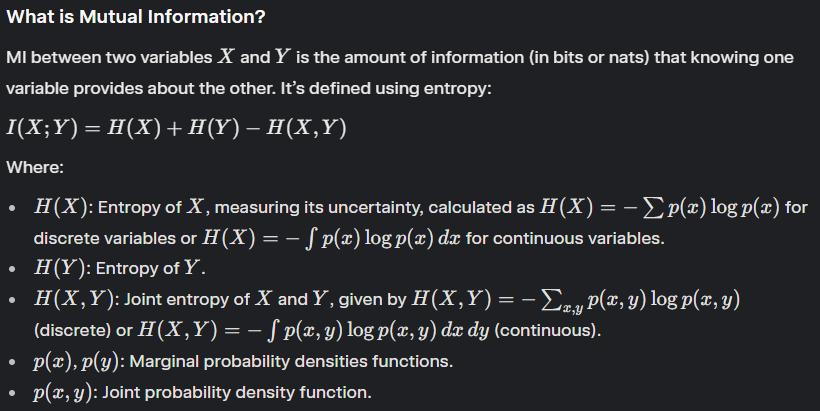

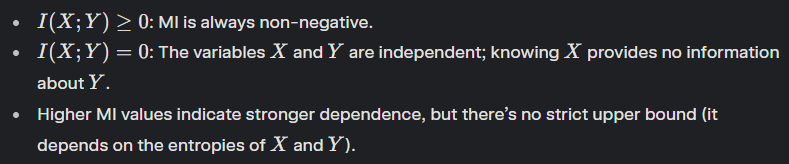

In [9]:
outputs = pd.read_excel("../dataset/original_health_data.xlsx")
output_indexes = outputs.iloc[:, -3:]

In [10]:
from sklearn.feature_selection import mutual_info_regression 

# calculate the mutual information between inputs -> outputs
def calculate_mutual_information(inputs, outputs):
    mut_inf_matrix = np.empty((inputs.shape[1], 0))

    for index in outputs.columns:
        vec_mi = []
        vec_mi = mutual_info_regression(inputs, outputs[index])
        mut_inf_matrix = np.column_stack([mut_inf_matrix, vec_mi])
        print(f"Mutual information for {index} index is calculated ...")
    
    df_mutinf = pd.DataFrame(mut_inf_matrix, index = inputs.columns, columns=outputs.columns)

    return df_mutinf

In [11]:
# dataframe of mutual information relevance
df_mi = calculate_mutual_information(dataset, output_indexes)

Mutual information for Kerdo index is calculated ...
Mutual information for Starr index is calculated ...
Mutual information for Robinson index is calculated ...


In [12]:
df_mi.head()

,Kerdo,Starr,Robinson
x1,0.000000,0.000000,0.000000
x2,0.049640,0.139524,0.000000
x3,0.000000,0.000000,0.000000
x4,0.078141,0.000000,0.052476
x5,0.000000,0.000000,0.048106


In [13]:
# plot heatmap of mutual information values
def plot_heatmap_mi(data):
    plt.figure(figsize=(10, 14))
    sns.heatmap(
        data, 
        annot=True,          # Show values in cells
        cmap="YlOrRd",      # Color map (yellow-orange-red)
        fmt=".2f",          # Decimal formatting
        linewidths=0.5,     # Add grid lines
        cbar_kws={"label": "Relevance"}  # Color bar label
    )

    # Customize labels
    plt.title("Mutual Information Measurement (Non-linear effects)", pad=20)
    plt.xlabel("Health Indexes")
    plt.ylabel("Input Features (Row Index)")

    plt.show()

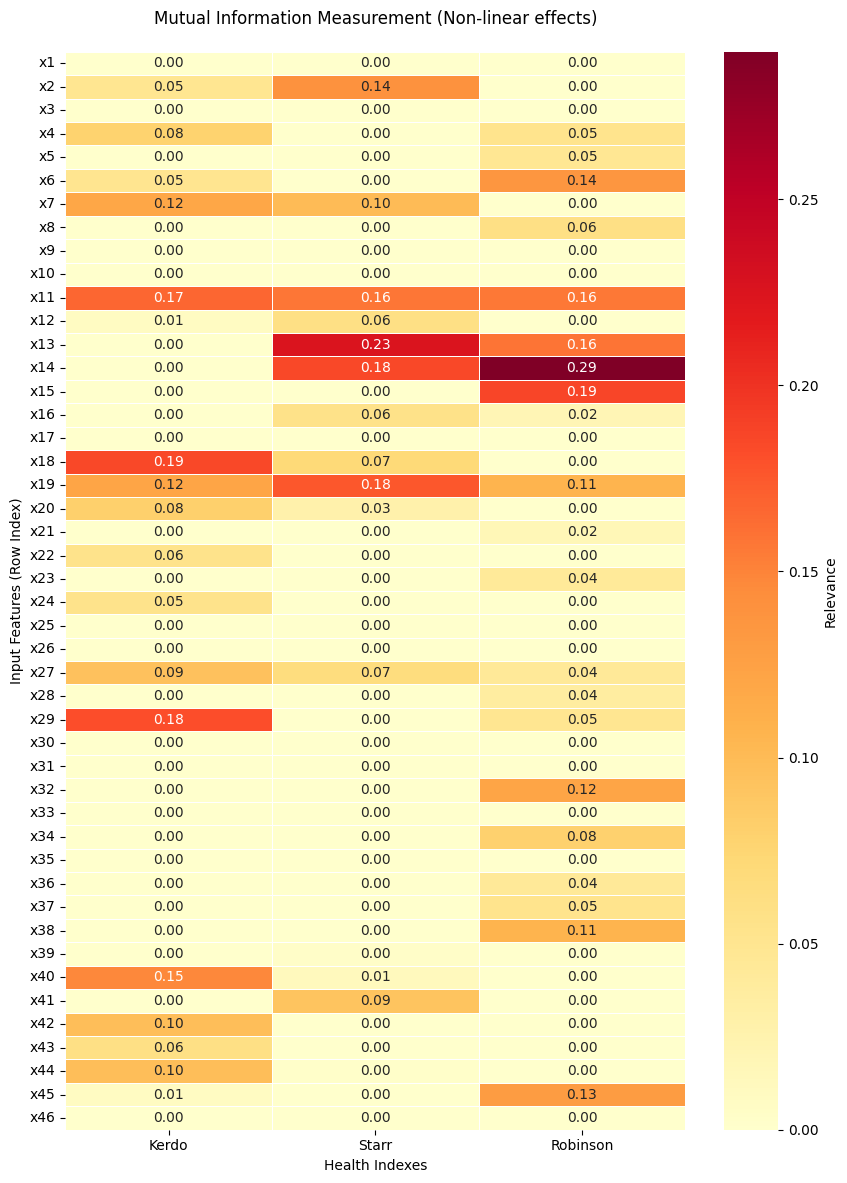

In [14]:
plot_heatmap_mi(df_mi)

In [15]:
def get_top_features_dict(df, top_k = 5):
    top_features_dict = {}
    
    for output_var in df.columns:
        # Get top-N features for this output
        top_features = (
            df[output_var]
            .sort_values(ascending=False)  # Sort by MI score (highest first)
            .head(top_k)                  # Take top N
            .index                        # Get feature names
            .tolist()                     # Convert to list
        )
        
        top_features_dict[output_var] = top_features
    
    return top_features_dict

In [16]:
dict_topk_features = get_top_features_dict(df_mi)

In [17]:
dict_topk_features

{'Kerdo': ['x18', 'x29', 'x11', 'x40', 'x19'],
 'Starr': ['x13', 'x14', 'x19', 'x11', 'x2'],
 'Robinson': ['x14', 'x15', 'x13', 'x11', 'x6']}

In [18]:
def generate_subsets(dataset, outputs, dict_top_features):
    for output in outputs.columns:
        # generate subset dataframe
        unified_columns = []
        data_matrix = np.empty((dataset.shape[0], 0))
        x = dataset.loc[:, dict_top_features[output]]
        y = outputs[output]
        data_matrix = np.column_stack([x, y])
        unified_columns = x.columns.to_list() + [output]
        # store subset in excel file
        df = pd.DataFrame(data_matrix, columns = unified_columns)
        df.to_excel(f"../subsets/data_index_{output}_v2.xlsx", index = False)

In [19]:
generate_subsets(dataset, output_indexes, dict_topk_features)

### 4) Hierarchical Clusterization

In [20]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage

In [21]:
def hierarchical_clusterization(data, corr_matrix):
    variables = data.columns
    distance_matrix = 1- corr_matrix
    np.fill_diagonal(distance_matrix, 0)

    # Use linkage to create clusters
    condense_dist = squareform(distance_matrix, checks=False)
    Z = linkage(condense_dist, method='average')

    # Plot dendrogram
    plt.figure(figsize=(10, 6))
    dendrogram(Z, labels=variables, orientation='top', leaf_rotation=90)
    plt.title("Dendrogram of Variable Similarity")
    plt.ylabel("Distance (1 - Correlation)")
    plt.show()

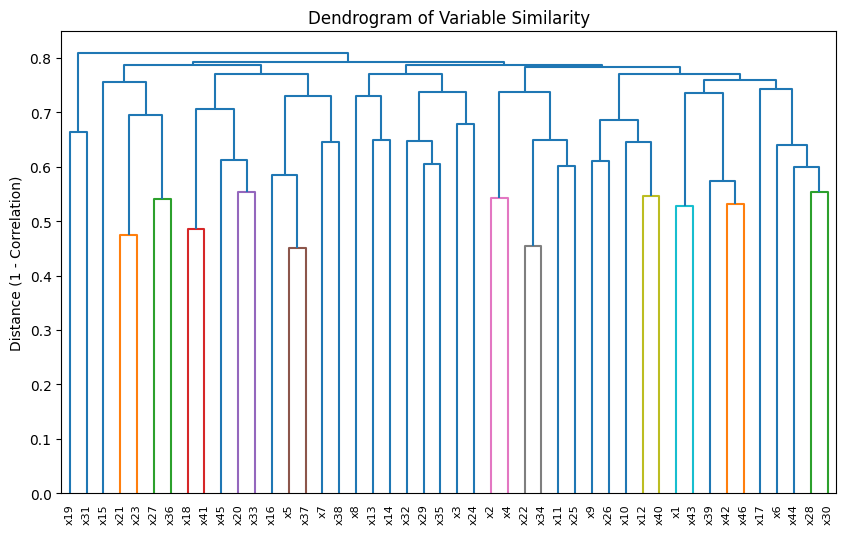

In [22]:
hierarchical_clusterization(dataset, corr_matrix)

Selection of subgroups of features for dimensionality reduction

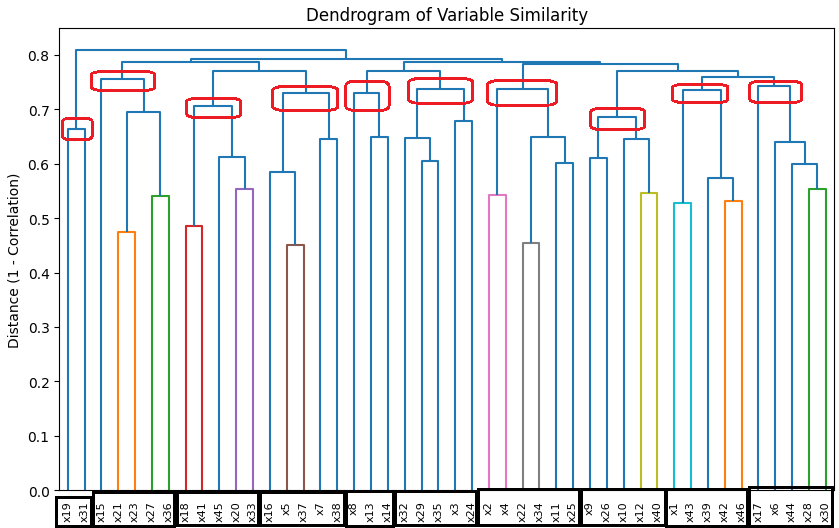